In [7]:
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
import scanpy as sc
from sklearn.neighbors import kneighbors_graph
from torch_geometric.data import Data
from torch_geometric.utils import add_remaining_self_loops

import torch.nn.functional as F
from torch_geometric.nn import GATv2Conv, GCNConv
import torch.nn as nn

from sklearn.model_selection import StratifiedKFold
import seaborn as sns
from graphFeatureSelect.utils import get_adata
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression
from sklearn.metrics import accuracy_score

from sklearn.model_selection import StratifiedKFold


custom_params = {"axes.spines.right": False, "axes.spines.top": False}
sns.set_theme(style="ticks", font_scale=0.5, rc=custom_params)
%config InlineBackend.figure_format="retina"

In [11]:
adata = get_adata("../data/VISp.h5ad")

# selecting 1 layer of anndata
# use supertype not subclass
display(adata.obs[["brain_section_label", "z_section"]].sort_values("z_section").value_counts().to_frame().head(4))
one_sec = adata[adata.obs["z_section"] == 5.0, :]
df = one_sec.obs.copy()
num_nodes = df.shape[0]
cell_type = "supertype"

# creating train/test masks
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Keep cells who are participants in the multilayer graph (more than 1 connection)
train_idx, test_idx = next(skf.split(np.arange(df.shape[0]), df[cell_type].values))

train_mask = np.zeros(df.shape[0], dtype=bool)
train_mask[train_idx] = True
train_mask = torch.tensor(train_mask, dtype=torch.bool)

test_mask = np.zeros(df.shape[0], dtype=bool)
test_mask[test_idx] = True
test_mask = torch.tensor(test_mask, dtype=torch.bool)

labels = torch.tensor(df[cell_type].cat.codes.values, dtype=torch.long)

# constructing edges with nearest neighbors
k = 10
X = df[["x_reconstructed", "y_reconstructed"]]

A = kneighbors_graph(X, n_neighbors=k, mode="distance", include_self=False)

edgelist_knn = torch.tensor(list(zip(A.tocoo().row, A.tocoo().col)))
edgelist_knn = add_remaining_self_loops(edgelist_knn.T)[0]

edgelist_self = torch.tensor([[i, i] for i in range(num_nodes)])
edgelist_self = edgelist_self.T

one_sec_x = torch.tensor(one_sec.X.todense(), dtype=torch.float)
one_sec_x = one_sec_x[:, :10] #  10 genes as input
data_knn = Data(x=one_sec_x, edge_index=edgelist_knn, y=labels, train_mask=train_mask, test_mask=test_mask)
data_self = Data(x=one_sec_x, edge_index=edgelist_self, y=labels, train_mask=train_mask, test_mask=test_mask)

/data/users1/dkim195/miniconda3/envs/allen/lib/python3.10/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


,,count
brain_section_label,z_section,
C57BL6J-638850.30,5.0,9242
C57BL6J-638850.29,4.8,8713
C57BL6J-638850.28,4.6,7780
C57BL6J-638850.31,5.4,6939


/data/users1/dkim195/miniconda3/envs/allen/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


In [13]:
class GATConcrete(torch.nn.Module):
    def __init__(self, hidden_channels, num_features, num_classes, n_mask):
        super().__init__()
        torch.manual_seed(1234567)
        self.concrete = nn.Parameter(torch.randn(n_mask, num_features))
        self.hidden_channels = hidden_channels
        self.conv1 = GATv2Conv(num_features, hidden_channels, heads = 8, concat = False)
        self.conv2 = GATv2Conv(hidden_channels, num_classes, heads = 8, concat = False)
        self.lin1 = nn.Linear(num_features, num_classes)

        self.dropout = nn.Dropout(0.25)
    def forward(self, x, edge_index, temp, hard_):
        mask = F.gumbel_softmax(self.concrete, tau=temp, hard=hard_)
        mask = torch.sum(mask, axis=0)
        mask = torch.clamp(mask, min=0, max=1)
        x = mask * x

        residual1 = self.lin1(x)
        
        out = self.conv1(x, edge_index)
        out = out.relu()
        out = self.dropout(out)
        
        out = self.conv2(out, edge_index)
        out = out + residual1

        return out

In [28]:
learning_rate = 0.001

In [29]:
def exp_decay_temp_schedule(epoch, total_epoch):
    start_temp = 10
    end_temp = 0.01
    temp = start_temp * (end_temp / start_temp) ** (epoch / total_epoch)
    return temp

def train_gnn(model, optimizer, data, criterion, epoch, num_epochs):
    model.train()
    optimizer.zero_grad()  # Clear gradients.
    out = model(data.x, data.edge_index, exp_decay_temp_schedule(epoch, num_epochs), False)  # Perform a single forward pass.
    loss = criterion(
        out[data.train_mask], data.y[data.train_mask]
    )  # Compute the loss solely based on the training nodes.
    loss.backward()  # Derive gradients.
    optimizer.step()  # Update parameters based on gradients.
    return loss

def test_gnn(model, data):
    model.eval()
    out = model(data.x, data.edge_index, 0.01, True)
    pred = out.argmax(dim=1)  # Use the class with highest probability.
    test_correct = pred[data.test_mask] == data.y[data.test_mask]  # Check against ground-truth labels.
    test_acc = int(test_correct.sum()) / int(data.test_mask.sum())  # Derive ratio of correct predictions.
    return test_acc


def training_loop(model, data, total_epoch):
    optimizer_self = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=5e-4)
    criterion = torch.nn.CrossEntropyLoss()
    loss_list = []
    for epoch in range(1, total_epoch + 1):
        loss = train_gnn(model, optimizer_self, data, criterion, epoch, total_epoch)
        val_acc = test_gnn(model, data)
        if epoch % 5 == 0:
            print(f"Epoch: {epoch:03d}, Loss: {loss:.4f}, Val acc: {val_acc:.4f}")
        loss_list.append(loss.detach().numpy())
    model.eval()
    val_acc = test_gnn(model, data)
    print(f"Model accuracy: {val_acc:.4f}")
    return val_acc, loss_list

In [30]:
GAT_conc = GATConcrete(hidden_channels=32, num_features=data_knn.x.shape[1], num_classes=torch.unique(data_knn.y).size()[0], n_mask=3)

Epoch: 005, Loss: 4.5954, Val acc: 0.0097
Epoch: 010, Loss: 4.5487, Val acc: 0.0108
Epoch: 015, Loss: 4.5004, Val acc: 0.0135
Epoch: 020, Loss: 4.4491, Val acc: 0.0406
Epoch: 025, Loss: 4.3905, Val acc: 0.0379
Epoch: 030, Loss: 4.3261, Val acc: 0.0384
Epoch: 035, Loss: 4.2587, Val acc: 0.0324
Epoch: 040, Loss: 4.1784, Val acc: 0.0362
Epoch: 045, Loss: 4.0919, Val acc: 0.0530
Epoch: 050, Loss: 4.0028, Val acc: 0.0427
Epoch: 055, Loss: 3.9192, Val acc: 0.0314
Epoch: 060, Loss: 3.8195, Val acc: 0.0341
Epoch: 065, Loss: 3.7279, Val acc: 0.1449
Epoch: 070, Loss: 3.6375, Val acc: 0.0449
Epoch: 075, Loss: 3.5512, Val acc: 0.0384
Epoch: 080, Loss: 3.4743, Val acc: 0.1379
Epoch: 085, Loss: 3.4074, Val acc: 0.1055
Epoch: 090, Loss: 3.3448, Val acc: 0.1401
Epoch: 095, Loss: 3.3026, Val acc: 0.0552
Epoch: 100, Loss: 3.2433, Val acc: 0.1439
Epoch: 105, Loss: 3.2095, Val acc: 0.1422
Epoch: 110, Loss: 3.1978, Val acc: 0.0914
Epoch: 115, Loss: 3.1723, Val acc: 0.1471
Epoch: 120, Loss: 3.1505, Val acc:

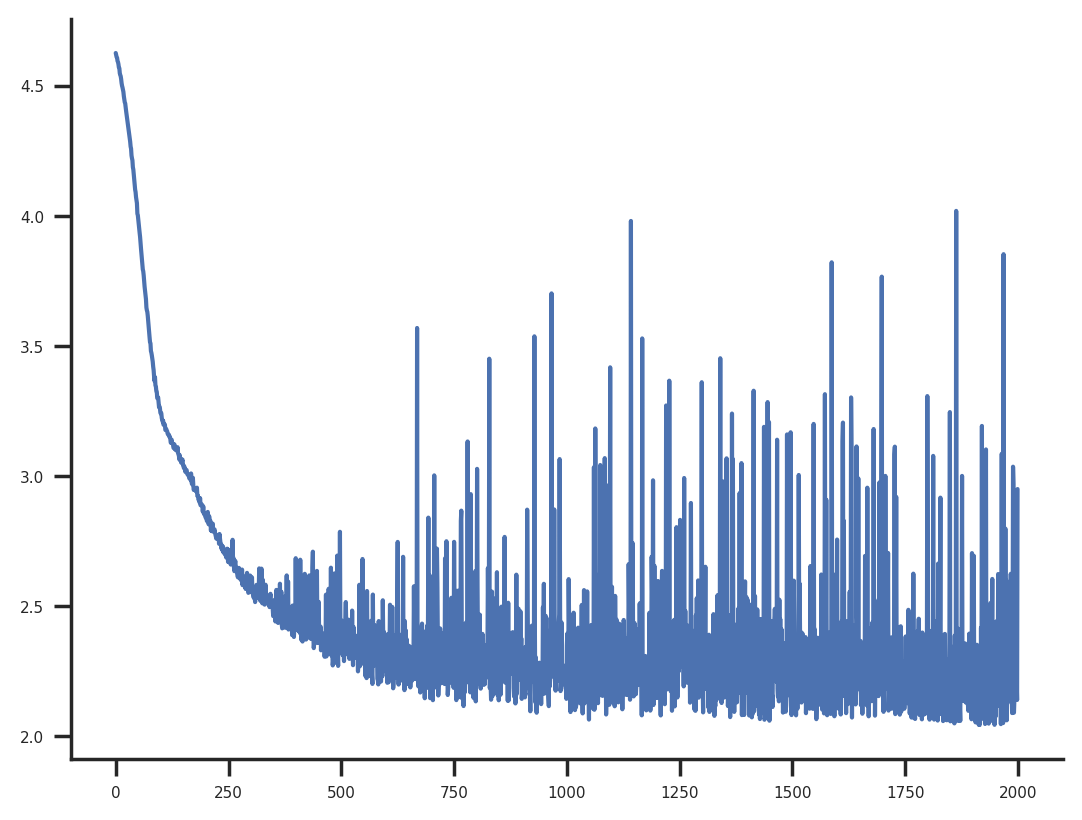

In [31]:
# GAT KNN 3
val_acc, loss_list = training_loop(GAT_conc, data_knn, 2000)
plt.plot(loss_list)

In [21]:
# MLP classifier to predict celltypes (baseline)
from sklearn.neural_network import MLPClassifier

clf = MLPClassifier()
clf.fit(one_sec_x[train_mask], labels[train_mask])

/data/users1/dkim195/miniconda3/envs/allen/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


MLPClassifier()

In [23]:
np.round(clf.score(one_sec_x[test_mask], labels[test_mask]), 2)

np.float64(0.44)